# Massachussets School Data

## Libraries

In [1]:
import os
import pandas
import numpy
import math
import matplotlib
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold

## Settings

In [2]:
number_of_bootstraps = 100
feature_occurance_ratio = 0.75
filename = "MA_Public_Schools_2017.csv"
start_year = 2010
stop_year = 2017
y_column_name = "% Graduated"
y_groups = 2
keep_columns = [
    "% Economically Disadvantaged",
    "% First Language Not English",
    "% High Needs",
    "% English Language Learner",
    "# in Cohort",
    "Number of Students",
    "Average Expenditures per Pupil",
#     "FTE Count",
#     "Total # of Classes",
#     "Salary Totals",
#     "% African American",
#     "Total Expenditures",
#     "In-District Expenditures",
#     "Average Salary",
]
one_hot_encode = ["School Type", "Function"]
floatify_columns = ["AP_Test Takers", "AP_Tests Taken"]
levelize_columns = ["Accountability and Assistance Level", "District_Accountability and Assistance Level"]
gradify_columns = ["Grade"]
fill_na_0s = [
    "AP_Test Takers",
    "AP_Tests Taken",
    "AP_One Test",
    "AP_Two Tests",
    "AP_Three Tests",
    "AP_Four Tests",
    "AP_Five or More Tests",
    "AP_Score=1",
    "AP_Score=2",
    "AP_Score=3",
    "AP_Score=4",
    "AP_Score=5",
    "% AP_Score 1-2",
    "% AP_Score 3-5",
]

## Load the data

In [3]:
df = pandas.read_csv(filename)

In [4]:
df

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,Pioneer Charter School of Science II (PCSS-II),Charter School,Principal,Vahit Sevinc,97 Main Street,NaN,Saugus,MA,1906,...,30.0,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1857,35100205,Springfield Preparatory Charter School,Charter School,Principal,Bill Spirer,370 Pine St.,NaN,Springfield,MA,1105,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1858,39020900,TEC Connections Academy Commonwealth Virtual S...,Public School,Principal,Adam Goldberg,141 Mansion Drive,NaN,East Walpole,MA,2032,...,28.0,Level 3,Very low assessment participation (Less than 90%),NaN,NaN,NaN,Level 3,Very low assessment participation (Less than 90%),NaN,NaN
1859,35050405,UP Academy Charter School of Dorchester,Charter School,Principal,Jabari Peddie,35 Westville Street,NaN,Boston,MA,2124,...,NaN,Level 1,Meeting gap narrowing goals,35.0,92.0,98.0,Level 1,Meeting gap narrowing goals,92.0,98.0


In [5]:
for column in df.columns:
    print(column)

School Code
School Name
School Type
Function
Contact Name
Address 1
Address 2
Town
State
Zip
Phone
Fax
Grade
District Name
District Code
PK_Enrollment
K_Enrollment
1_Enrollment
2_Enrollment
3_Enrollment
4_Enrollment
5_Enrollment
6_Enrollment
7_Enrollment
8_Enrollment
9_Enrollment
10_Enrollment
11_Enrollment
12_Enrollment
SP_Enrollment
TOTAL_Enrollment
First Language Not English
% First Language Not English
English Language Learner
% English Language Learner
Students With Disabilities
% Students With Disabilities
High Needs
% High Needs
Economically Disadvantaged
% Economically Disadvantaged
% African American
% Asian
% Hispanic
% White
% Native American
% Native Hawaiian, Pacific Islander
% Multi-Race, Non-Hispanic
% Males
% Females
Total # of Classes
Average Class Size
Number of Students
Salary Totals
Average Salary
FTE Count
In-District Expenditures
Total In-district FTEs
Average In-District Expenditures per Pupil
Total Expenditures
Total Pupil FTEs
Average Expenditures per Pupil
# i

In [6]:
df.isna().sum().sum()

380677

## Fix the data

In [7]:
df_encoded = df.copy()

In [8]:
numpy.array(df_encoded["School Type"]).reshape(-1, 1)

array([['Public School'],
       ['Public School'],
       ['Public School'],
       ...,
       ['Public School'],
       ['Charter School'],
       ['Charter School']], dtype=object)

### One-Hot encode certain features

In [9]:
for column_name in one_hot_encode:
    encoder = OneHotEncoder(sparse=False)
    column = numpy.array(df_encoded[column_name][df_encoded[column_name].notna()]).reshape(-1, 1)
    encoder.fit(column)
    indices = df_encoded[column_name][df_encoded[column_name].notna()].index
    for i in range(len(encoder.categories_[0])):
        new_column_name = column_name + ": " + encoder.categories_[0][i]
        df_encoded = pandas.merge(df_encoded, pandas.DataFrame({new_column_name: encoder.transform(column)[:, i]}), left_index = True, right_index = True)
    df_encoded = df_encoded.drop(column_name, 1)

### Clean up other features
(Turn levels into numbers, convert grade leveling into separate features, etc.)

In [10]:
df_clean = df_encoded

for column in floatify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is str:
            df_clean.loc[row, column] = float(df_clean.loc[row, column].replace(',', ''))

for column in levelize_columns:
    for row in range(df_clean.shape[0]):
        value = df_clean.loc[row, column]
        if value == "Insufficient data":
            df_clean.loc[row, column] = numpy.nan
        elif value == "Level 1":
            df_clean.loc[row, column] = 1
        elif df_clean.loc[row, column] == "Level 2":
            df_clean.loc[row, column] = 2
        elif df_clean.loc[row, column] == "Level 3":
            df_clean.loc[row, column] = 3
        elif df_clean.loc[row, column] == "Level 4":
            df_clean.loc[row, column] = 4
        elif df_clean.loc[row, column] == "Level 5":
            df_clean.loc[row, column] = 5

grades = ["PK", "K", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

for grade in grades:
    df_clean["Grade " + grade] = numpy.full(df_clean.shape[0], 0)

for column in gradify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is not float:
            for current_grade in df_clean.loc[row, column].replace("0", "").split(","):
                df_clean.loc[row, "Grade " + current_grade] = 1

    df_clean = df_clean.drop(column, 1)

for column_name in fill_na_0s:
    column = df_clean[column_name]
    column[column.isna()] = 0

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
df_clean.isna().sum().sum()

359118

In [12]:
# Columns that were removed
for column in df.columns:
    if column not in df_clean.columns:
        print(column)

School Type
Function
Grade


### Keep only the good features

In [13]:
keep_columns.append(y_column_name)
df_slim = df_clean[keep_columns]

In [14]:
df_slim.shape

(1861, 8)

## Make the Y column usable
(by turning it into a classification based on the mean Y and removing all NA rows)

In [15]:
df_slim[y_column_name].describe()

count    376.000000
mean      83.327394
std       21.459396
min        0.000000
25%       82.150000
50%       92.250000
75%       96.200000
max      100.000000
Name: % Graduated, dtype: float64

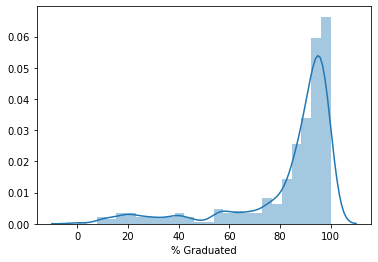

In [16]:
seaborn.distplot(df_slim[y_column_name][df_slim[y_column_name].notna()])

In [17]:
df_slim[y_column_name].isna().sum() / df.shape[0]

0.7979580870499732

In [18]:
df_slim.isna().sum().sum() / (df.shape[0] * df.shape[1])

0.005595866353986143

In [19]:
df_fixed_y_column = df_slim[df_slim[y_column_name].notna()]
df_fixed_y_column

,% Economically Disadvantaged,% First Language Not English,% High Needs,% English Language Learner,# in Cohort,Number of Students,Average Expenditures per Pupil,% Graduated
0,21.5,5.3,28.8,2.4,114.0,451.0,13270.84,94.7
8,22.7,4.6,32.0,1.3,325.0,1242.0,14363.21,94.2
16,14.6,2.9,25.9,0.5,163.0,621.0,13771.87,93.9
17,74.2,0.0,83.9,0.0,9.0,33.0,13771.87,66.7
23,6.3,9.5,20.9,0.8,441.0,1799.0,15601.70,95.7
...,...,...,...,...,...,...,...,...
1826,58.6,57.3,75.9,31.5,322.0,1268.0,13901.25,76.4
1831,57.1,68.5,68.5,25.6,41.0,250.0,13901.25,92.7
1838,43.8,40.6,57.0,8.0,315.0,1348.0,13901.25,95.9
1851,47.8,1.0,55.2,1.0,45.0,637.0,NaN,40.0


In [20]:
nas = df_fixed_y_column[df_fixed_y_column[y_column_name].notna()].isna().sum()
drop_columns = []
for column in range(len(df_fixed_y_column.columns)):
    percent_na = nas[column] / df_fixed_y_column.shape[0]
    if percent_na > 0.90:
        drop_columns.append(df_fixed_y_column.columns[column])
df_final = df_fixed_y_column.drop(drop_columns, 1)

In [21]:
# Columns that were removed
for column in df_fixed_y_column.columns:
    if column not in df_final.columns:
        print(column)

In [22]:
df_final.isna().sum().sum() / (df_final.shape[0] * df_final.shape[1])

0.013962765957446808

In [23]:
df_final[y_column_name] = OrdinalEncoder().fit_transform(numpy.array(df_final[y_column_name] > df_final[y_column_name].mean()).reshape(-1, 1))
df_final[y_column_name]

0       1.0
8       1.0
16      1.0
17      0.0
23      1.0
       ... 
1826    0.0
1831    1.0
1838    1.0
1851    0.0
1858    0.0
Name: % Graduated, Length: 376, dtype: float64

## Fit the remaining data
Pipeline:
* Iterative Imputer - fixes NA's with a fit of the data that predicts what the NA "probably" should be
* Scaler - All data is scaled and normalized down based on each feature's interquartile range and median (to protect agains outliers)
* Selector - Cut out most of the features that do not add information to the final model
* Model - A feature-selecting Logistic model (feature selection is provided by Stocahstic Gradient Descent)

In [24]:
balanced_accuracy_scores = []
accuracy_scores = []
jaccard_scores = []
probabilities_low = []
probabilities_high = []
coefs = {}

for column in df_final.columns:
    if column != y_column_name:
        coefs[column] = []

for run in range(number_of_bootstraps):
    print("Run {0}".format(run))
    
    # Split X and Y
    x = df_final.drop(y_column_name, 1)
    y = df_final[y_column_name]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    # Recombine the X and Y of the training data
    df_train = pandas.merge(pandas.DataFrame(x_train), pandas.DataFrame(y_train), left_index=True, right_index=True)
    
    # Balance the groups in the training data (with resampling)
    lengths = []
    group_1_len = df_train[df_train[y_column_name] == 1].shape[0]
    df_train = pandas.concat([
        resample(df_train[df_train[y_column_name] == 1], n_samples=group_1_len),
        resample(df_train[df_train[y_column_name] == 0], n_samples=group_1_len)
    ])
    
    # Resplit X and Y
    x_train = df_train.drop(y_column_name, 1)
    y_train = df_train[y_column_name]
    
    # Create the pipeline
    imputer = IterativeImputer(verbose=True) # Fills in the N/A's using similar entries and regression
    scaler = RobustScaler() # Center and scale the values
#     selector_1 = VarianceThreshold(threshold=0.5) # 0.0: 101, 0.1: 91, 0.2: 88, 0.3: 85, 0.4: 82, 0.5: 78
#     selector_2 = RFECV(SGDClassifier(loss="log", penalty="l1", average=1), scoring="accuracy", step=1, cv=5)
    model = SGDClassifier(loss="log", penalty="l1", average=1)
    pipeline = Pipeline(steps=[
        ("imputer", imputer),
        ("scaler", scaler),
#         ("selector_1", selector_1),
#         ("selector_2", selector_2),
        ("model", model)
    ], verbose=True)
    
    # Pipeline Classification
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    probabilties = pipeline.predict_proba(x_test)
    probabilities_low.append(probabilties[0][probabilties[0] > 0.5].mean())
    probabilities_high.append(probabilties[1][probabilties[1] > 0.5].mean())
    
    # Accuracy Score
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Balanced Accuracy Score
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    
    # Jaccard Score
    jaccard_scores.append(jaccard_score(y_test, y_pred))
    
    # Feature Importances
    current_coefficients = model.coef_[0]
    magnitudes_scaler = RobustScaler(with_centering=False)
    current_scaled_coefficients = magnitudes_scaler.fit_transform(numpy.array(current_coefficients).reshape(-1, 1))
    for index in range(len(current_scaled_coefficients)):
        column = x_train.columns[index]
        coef = current_scaled_coefficients[index][0]
        coefs[column].append(coef)

Run 0
[IterativeImputer] Completing matrix with shape (446, 7)
[IterativeImputer] Change: 4006.7885277237037, scaled tolerance: 27.56887 
[IterativeImputer] Change: 30.393145629990613, scaled tolerance: 27.56887 
[IterativeImputer] Change: 0.29797074956150027, scaled tolerance: 27.56887 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 1
[IterativeImputer] Completing matrix with shape (438, 7)
[IterativeImputer] Change: 2895.3640631131566, scaled tolerance: 27.61375 
[IterativeImputer] Change: 22.766305171517473, scaled tolerance: 27.61375 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0

[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 14
[IterativeImputer] Completing matrix with shape (450, 7)
[IterativeImputer] Change: 3769.8268942808572, scaled tolerance: 28.20795 
[IterativeImputer] Change: 21.8301065497144, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 15
[IterativeImputer] Completing matrix with shape (450, 7)
[IterativeImputer] Change: 4479.010318287294, scaled tolerance: 28.20795 
[IterativeImputer]

[IterativeImputer] Change: 620.4097143564624, scaled tolerance: 28.20795 
[IterativeImputer] Change: 0.010736145962269461, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 28
[IterativeImputer] Completing matrix with shape (446, 7)
[IterativeImputer] Change: 3778.9564749743877, scaled tolerance: 28.20795 
[IterativeImputer] Change: 37.34233786447538, scaled tolerance: 28.20795 
[IterativeImputer] Change: 0.4376495656233885, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.2s
[Pipeline] ............ (step 2 of 3) Processing scaler, to

[IterativeImputer] Change: 3512.789371631272, scaled tolerance: 28.20795 
[IterativeImputer] Change: 34.22571027437718, scaled tolerance: 28.20795 
[IterativeImputer] Change: 0.2144934115587489, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 42
[IterativeImputer] Completing matrix with shape (436, 7)
[IterativeImputer] Change: 3259.4270063402982, scaled tolerance: 28.20795 
[IterativeImputer] Change: 10.527099330150463, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, tota

[IterativeImputer] Completing matrix with shape (430, 7)
[IterativeImputer] Change: 3571.694795398942, scaled tolerance: 27.61375 
[IterativeImputer] Change: 7.791376158761167, scaled tolerance: 27.61375 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 56
[IterativeImputer] Completing matrix with shape (428, 7)
[IterativeImputer] Change: 5002.072276966306, scaled tolerance: 27.56887 
[IterativeImputer] Change: 39.08654727527065, scaled tolerance: 27.56887 
[IterativeImputer] Change: 0.19408669506731258, scaled tolerance: 27.56887 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipe

[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 69
[IterativeImputer] Completing matrix with shape (454, 7)
[IterativeImputer] Change: 738.5318410174406, scaled tolerance: 27.56887 
[IterativeImputer] Change: 0.002427403058021582, scaled tolerance: 27.56887 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 70
[IterativeImputer] Completing matrix with shape (430, 7)
[IterativeImputer] Change: 4600.095970251858, scaled tolerance: 28.20795 
[IterativeImputer] Change: 20.21283367670725, scaled tolerance: 28.20795 
[IterativeIm

[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 83
[IterativeImputer] Completing matrix with shape (432, 7)
[IterativeImputer] Change: 3925.79789449037, scaled tolerance: 27.61375 
[IterativeImputer] Change: 34.298119858052615, scaled tolerance: 27.61375 
[IterativeImputer] Change: 0.3921171205335554, scaled tolerance: 27.61375 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 84
[IterativeImputer] Completing matrix with shape (454, 7)
[IterativeImputer

[IterativeImputer] Completing matrix with shape (432, 7)
[IterativeImputer] Change: 5175.963756871635, scaled tolerance: 28.20795 
[IterativeImputer] Change: 110.5526940086711, scaled tolerance: 28.20795 
[IterativeImputer] Change: 4.111271311823657, scaled tolerance: 28.20795 
[IterativeImputer] Early stopping criterion reached.
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.1s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[IterativeImputer] Completing matrix with shape (76, 7)
[IterativeImputer] Completing matrix with shape (76, 7)
Run 97
[IterativeImputer] Completing matrix with shape (446, 7)
[IterativeImputer] Change: 5217.481134500093, scaled tolerance: 27.56887 
[IterativeImputer] Change: 49.34741246641076, scaled tolerance: 27.56887 
[IterativeImputer] Change: 0.5858353775992668, scaled tolerance: 27.56887 
[IterativeImputer] Early stopping criterion reached.
[Pi

## Plots of the probabilities of prediction of each group's members

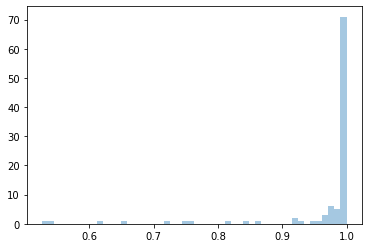

In [25]:
seaborn.distplot(probabilities_low, kde=False)

In [26]:
partial_accuracy = (1-0.95) / 2
probabilities_low_sorted = sorted(probabilities_low)
estimate = probabilities_low_sorted[int(number_of_bootstraps / 2)]
lower_ci = probabilities_low_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = probabilities_low_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

1.000 (0.614, 1.000)


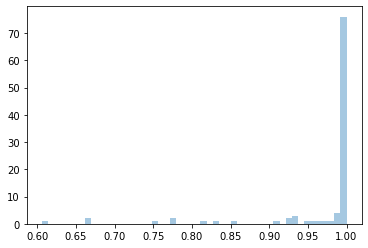

In [27]:
seaborn.distplot(probabilities_high, kde=False)

In [28]:
partial_accuracy = (1-0.95) / 2
probabilities_high_sorted = sorted(probabilities_high)
estimate = probabilities_high_sorted[int(number_of_bootstraps / 2)]
lower_ci = probabilities_high_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = probabilities_high_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

1.000 (0.663, 1.000)


## Accuracy of the model

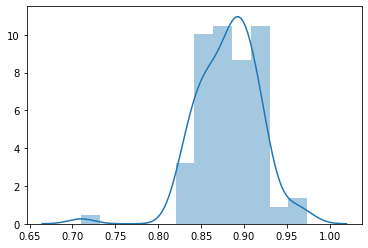

In [29]:
seaborn.distplot(accuracy_scores)

In [30]:
partial_accuracy = (1-0.95) / 2
accuracy_scores_sorted = sorted(accuracy_scores)
estimate = accuracy_scores_sorted[int(number_of_bootstraps / 2)]
lower_ci = accuracy_scores_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = accuracy_scores_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.882 (0.829, 0.961)


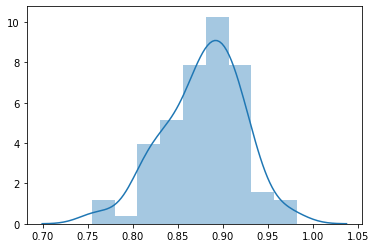

In [31]:
seaborn.distplot(balanced_accuracy_scores)

In [32]:
partial_accuracy = (1-0.95) / 2
balanced_accuracy_scores_sorted = sorted(balanced_accuracy_scores)
estimate = balanced_accuracy_scores_sorted[int(number_of_bootstraps / 2)]
lower_ci = balanced_accuracy_scores_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = balanced_accuracy_scores_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.886 (0.779, 0.960)


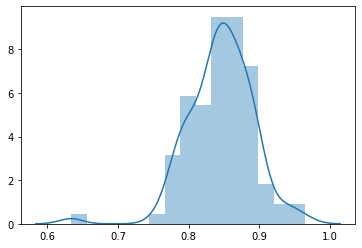

In [33]:
seaborn.distplot(jaccard_scores)

In [34]:
partial_accuracy = (1-0.95) / 2
jaccard_scores_sorted = sorted(jaccard_scores)
estimate = jaccard_scores_sorted[int(number_of_bootstraps / 2)]
lower_ci = jaccard_scores_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = jaccard_scores_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.846 (0.776, 0.942)


## Only look at features that are consistently used in the bootstrap

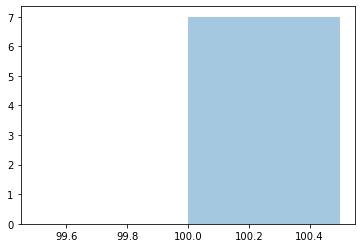

In [35]:
coef_lens = []
for k, v in coefs.items():
    coef_lens.append(len(v))
seaborn.distplot(coef_lens, kde=False)

## Get a look at what features are important, how important, and in what way
Because this is a logistic method we can't really look at the coefficients to figure out an exact amount that each feature impacts the final outcome like we can with a traditional linear model, but we can look at the following:
* Direction of the impact (+ or - sign indication towards or away from the higher group)
* Relative impact on the model compared to the other features' coefficients (bigger values mean more of an impact)
* How far away from 0 the coefficient is (closer to 0 means lower overall impact)
Therefore all the coefficients are scaled and ordered based on absolute scaled value to aid in understanding

In [36]:
estimates = {}
lower_ci = {}
upper_ci = {}

partial_accuracy = (1-0.95) / 2
for key, value in coefs.items():
    sorted_value = sorted(value)
    lower_ci[key] = sorted_value[int(number_of_bootstraps * partial_accuracy)]
    upper_ci[key] = sorted_value[int(number_of_bootstraps * (1-partial_accuracy))]
    estimates[key] = sorted_value[int(number_of_bootstraps / 2)]

estimates = pandas.DataFrame({
    "Scaled Estimate": pandas.Series(estimates),
    "Lower CI": pandas.Series(lower_ci),
    "Upper CI": pandas.Series(upper_ci),
})

estimates["Absolute Scaled Estimate"] = estimates["Scaled Estimate"].abs()

estimates = estimates.sort_values("Absolute Scaled Estimate", ascending=False)
for i in range(estimates.shape[0]):
    index = estimates.index[i]
    print("{0:<70.70}| {1: 4.4f} ({2: 4.4f}, {3: 4.4f})".format(
        index,
        estimates.loc[index, "Scaled Estimate"],
        estimates.loc[index, "Lower CI"],
        estimates.loc[index, "Upper CI"]
    ))

% High Needs                                                          | -1.0180 (-2.5972, -0.3356)
% First Language Not English                                          |  0.7498 ( 0.4963,  1.3443)
% English Language Learner                                            | -0.6345 (-0.9928, -0.2760)
Number of Students                                                    |  0.5945 ( 0.1137,  1.1787)
# in Cohort                                                           | -0.5287 (-0.8648, -0.0845)
% Economically Disadvantaged                                          | -0.4755 (-1.2229,  0.0252)
Average Expenditures per Pupil                                        |  0.1955 ( 0.0293,  0.4541)


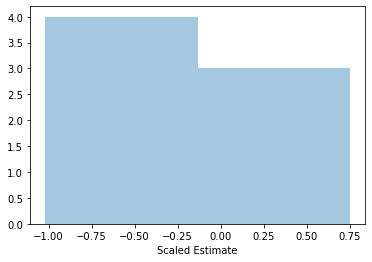

In [38]:
seaborn.distplot(estimates["Scaled Estimate"], kde=False)

## All coefficients for the entire bootstrap

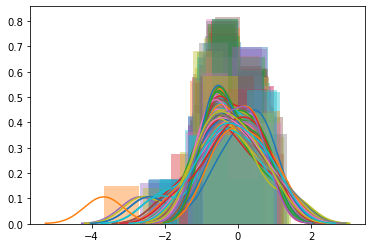

In [39]:
for i in range(number_of_bootstraps):
        this_set = []
        for key, value in coefs.items():
            if len(value) > i:
                this_set.append(value[i])
        seaborn.distplot(this_set)